<h1>Import & Load Data</h1>

In [9]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [2]:
# Load processed features
X = pd.read_csv("processed_data.csv")

# Load target (y)
raw = pd.read_csv("CarPrice_Assignment.csv")

# Target banalo
y = np.log1p(raw["price"])   # log transform target

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (205, 33)
y shape: (205,)


<h1>Preprocessing Setup</h1>

In [3]:
# Column types
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64","float64","Int64"]).columns.tolist()

# Numerical pipeline
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine
preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])


<h1>Train/Test Split</h1>

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [14]:
X_train['carmodels']

66          mazda_sedan
111       peugeot_sedan
153        toyota_wagon
96         nissan_sedan
38      honda_hatchback
             ...       
106    nissan_hatchback
14            bmw_sedan
92         nissan_sedan
179    toyota_hatchback
102        nissan_wagon
Name: carmodels, Length: 164, dtype: object

<h1>Define Models</h1>

In [5]:
# 1) Ridge
ridge = RidgeCV(alphas=np.logspace(-3,3,13), cv=5)
ridge_pipe = Pipeline([("prep", preprocess), ("model", ridge)])

# 2) Lasso
lasso = LassoCV(alphas=np.logspace(-3,1,20), cv=5, max_iter=10000, random_state=42)
lasso_pipe = Pipeline([("prep", preprocess), ("model", lasso)])

# 3) RandomForest
rf = RandomForestRegressor(
    n_estimators=600, max_depth=None, min_samples_leaf=2,
    random_state=42, n_jobs=-1
)
rf_pipe = Pipeline([("prep", preprocess), ("model", rf)])

# 4) XGBoost
xgb = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)
xgb_pipe = Pipeline([("prep", preprocess), ("model", xgb)])


<h1>Cross Validation & Summarizer</h1>

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"r2":"r2", "neg_mae":"neg_mean_absolute_error", "neg_rmse":"neg_root_mean_squared_error"}

def summarize_cv(name, res):
    r2 = res["test_r2"].mean()
    mae = -res["test_neg_mae"].mean()
    rmse = -res["test_neg_rmse"].mean()
    print(f"{name}: R2={r2:.3f} | MAE={mae:.3f} | RMSE={rmse:.3f}")

res_ridge = cross_validate(ridge_pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
res_lasso = cross_validate(lasso_pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
res_rf    = cross_validate(rf_pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
res_xgb   = cross_validate(xgb_pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)

summarize_cv("Ridge", res_ridge)
summarize_cv("Lasso", res_lasso)
summarize_cv("RandomForest", res_rf)
summarize_cv("XGBoost", res_xgb)


Ridge: R2=0.894 | MAE=0.128 | RMSE=0.162
Lasso: R2=0.890 | MAE=0.124 | RMSE=0.165
RandomForest: R2=0.918 | MAE=0.110 | RMSE=0.141
XGBoost: R2=0.923 | MAE=0.107 | RMSE=0.137


<h1>Final Model Selection + Evaluation Plots</h1>

In [10]:
# Fit best model (assume XGBoost was best in previous run)
best_pipe = xgb_pipe
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)

print("Final Model Performance:")
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))


Final Model Performance:
R2: 0.9506311852474515
MAE: 0.09375023122763095
RMSE: 0.01339300499960339


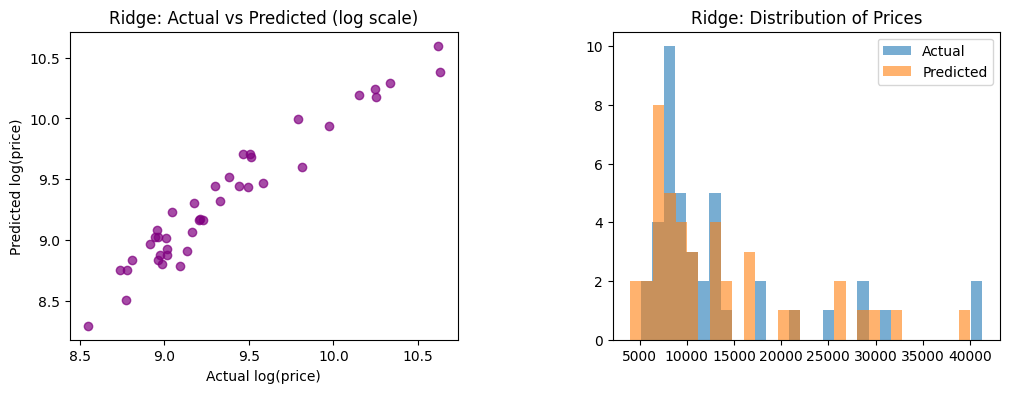

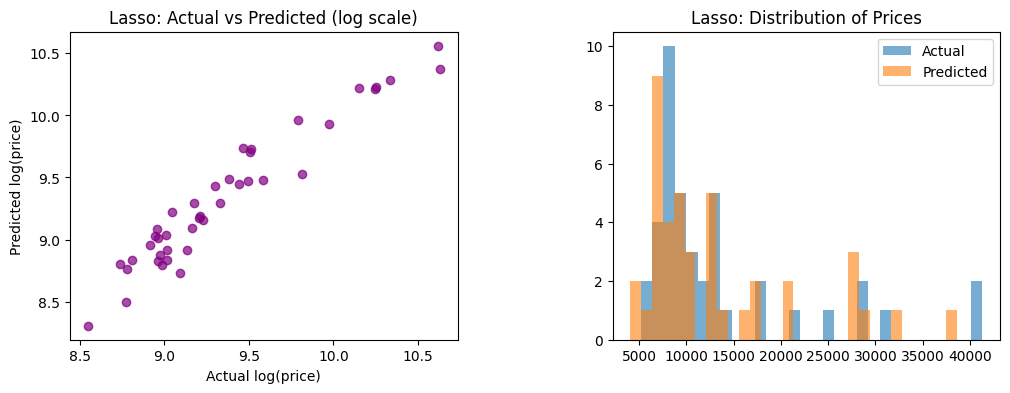

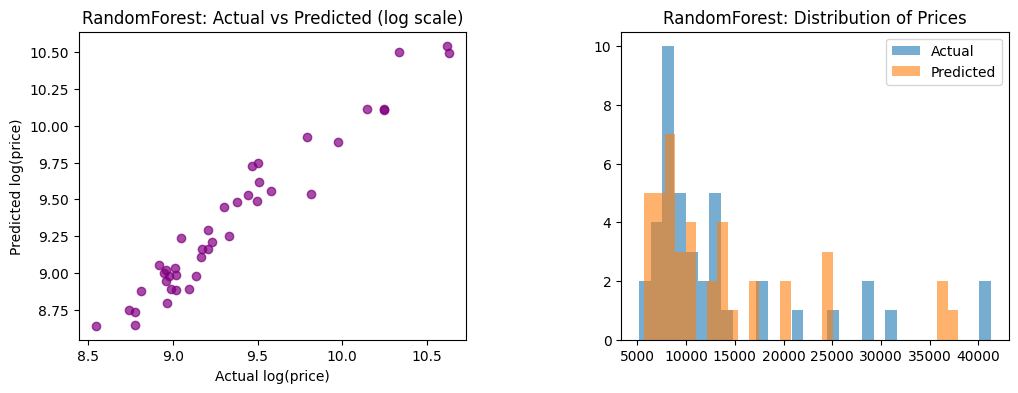

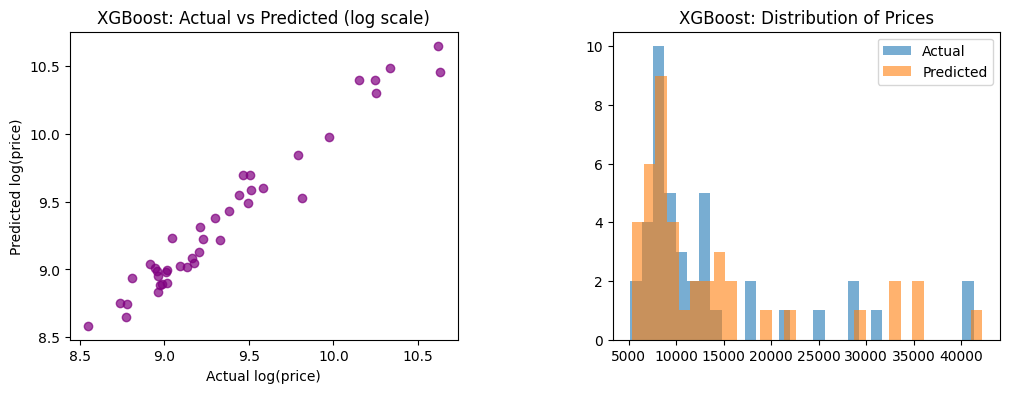

In [11]:
def plot_results(name, pipe):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Left: Actual vs Predicted log(price)
    axes[0].scatter(y_test, y_pred, c='purple', alpha=0.7)
    axes[0].set_title(f"{name}: Actual vs Predicted (log scale)")
    axes[0].set_xlabel("Actual log(price)")
    axes[0].set_ylabel("Predicted log(price)")

    # Right: Distribution comparison in original scale
    axes[1].hist(np.expm1(y_test), bins=30, alpha=0.6, label="Actual")
    axes[1].hist(np.expm1(y_pred), bins=30, alpha=0.6, label="Predicted")
    axes[1].set_title(f"{name}: Distribution of Prices")
    axes[1].legend()

    fig.subplots_adjust(wspace=0.4)
    plt.show()

# Plot for each model
plot_results("Ridge", ridge_pipe)
plot_results("Lasso", lasso_pipe)
plot_results("RandomForest", rf_pipe)
plot_results("XGBoost", xgb_pipe)


<h1>Save Best Model</h1>

In [12]:
joblib.dump({"pipeline": best_pipe}, "best_carprice_model.joblib")
print("✅ Saved best model as best_carprice_model.joblib")


✅ Saved best model as best_carprice_model.joblib
